In [4]:
import numpy as np
import pandas as pd
import re

In [5]:
train_df=pd.read_csv('/content/drive/MyDrive/RGC PROJECT/leaf/archive/train.csv')
train_df


image_id  width  height                  bbox
0     LEAF_0009.jpg   1024    1024  [473, 273, 289, 335]
1     LEAF_0009.jpg   1024    1024  [588, 516, 272, 318]
2     LEAF_0009.jpg   1024    1024  [510, 780, 218, 244]
3     LEAF_0009.jpg   1024    1024  [766, 822, 246, 201]
4     LEAF_0009.jpg   1024    1024    [1, 813, 240, 211]
...             ...    ...     ...                   ...
5341  LEAF_1112.jpg    416     416   [152, 43, 139, 345]
5342  LEAF_1112.jpg    416     416    [320, 80, 79, 261]
5343  LEAF_1113.jpg    416     416   [116, 34, 180, 313]
5344  LEAF_1114.jpg    416     416   [158, 11, 117, 397]
5345  LEAF_1115.jpg    416     416    [96, 84, 295, 225]

[5346 rows x 4 columns]

In [6]:
train_df['x']=-1

In [7]:
train_df['y']=-1

In [8]:
train_df['w']=-1

In [9]:
train_df['h']=-1

In [10]:
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

In [11]:
train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))

In [12]:
train_df.drop(columns=['bbox'], inplace=True)

In [13]:
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

<ipython-input-13-cfd906c8443f>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_df['x'] = train_df['x'].astype(np.float)
<ipython-input-13-cfd906c8443f>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_df['y'] = train_df['y'].astype(np.float)
<ipython-input-13-cfd906c8443f>:3: DeprecationWarning: `np.float` is a deprecated al

In [14]:
image_ids = train_df['image_id'].unique()

In [15]:
valid_ids = image_ids[-4:]

In [16]:
valid_ids = np.append(valid_ids,image_ids[:4])

In [17]:
train_ids = image_ids[4:-4]

In [18]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [19]:
valid_df.shape

(195, 7)

In [20]:
train_df.shape

(5151, 7)

In [21]:
!pip install "torch==1.4" "torchvision==0.5.0"

ERROR: Could not find a version that satisfies the requirement torch==1.4 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.4


In [22]:
!pip install opencv-python

In [23]:
pip install opencv-python-headless==4.5.5.62

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 24.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.0.76
    Uninstalling opencv-python-headless-4.8.0.76:
      Successfully uninstalled opencv-python-headless-4.8.0.76


In [24]:
import cv2
import torch

In [25]:
class LeafDataset():

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        image = np.reshape(image,image.shape+(1,))
        image /= 255.0
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [26]:
# !pip install -U albumentations==0.4.6

In [27]:

# !pip install --upgrade --force-reinstall --no-deps albumentations

In [28]:
# !pip install -U albumentations --no-binary qudida,albumentations

In [29]:
pip install albumentations


In [30]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


# from albumentations.pytorch import ToTensorV
from albumentations.pytorch import transforms

In [31]:
def transform():
    return A.Compose([ToTensorV2(p=1.0),], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def collate_fn(batch):
    return tuple(zip(*batch))

In [32]:
DIR_TRAIN='/content/drive/MyDrive/RGC PROJECT/leaf/archive/train'
DIR_TEST='/content/drive/MyDrive/RGC PROJECT/leaf/archive/test'

In [33]:
train_dataset = LeafDataset(train_df, DIR_TRAIN, transform())
valid_dataset = LeafDataset(valid_df, DIR_TRAIN, transform())

In [34]:
from torch.utils.data import Dataset, DataLoader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [36]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [37]:
from matplotlib import pyplot as plt
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from albumentations.pytorch import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from PIL import Image
import time


In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [39]:
def get_boxes(tensor,index,score=0.5):

    if index >= len(tensor)  or index<0:
        return 0

    temp_boxes = []
    for i in range(len(tensor[index]['boxes'])):
        if tensor[index]['scores'][i] > score:
            temp_boxes.append(tensor[index]['boxes'][i].cpu().detach().numpy().astype(np.int32))

    return temp_boxes
def get_sample_image(itr):
    images, targets, image_ids = next(it)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      0, 2)

    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')
def get_validation_image(itr):
    images, targets, image_ids = next(itr)
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    model.eval()
    outputs = model(images)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    boxes = get_boxes(outputs,0)
    # boxes = outputs[1]['boxes'].cpu().detach().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    boxes = get_boxes(outputs,0)
    sample = images[0].permute(1,2,0).cpu().numpy()
    sample = np.reshape(sample,(sample.shape[1],sample.shape[1]))
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in boxes:
        cv2.rectangle(sample,(box[0], box[1]),(box[2], box[3]),0, 2)
    ax.set_axis_off()
    ax.imshow(sample,cmap='gray')

def load_test_dataset():
    data_path = DIR_TEST
    test_dataset = torchvision.datasets.ImageFolder(root=data_path,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=1),
            torchvision.transforms.ToTensor(),]
    ))

    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,
        num_workers=1,shuffle=False
    )
    return test_loader

def get_test_image(itr,score = 0.5):
    image, targets= next(itr)
    sample = image
    image = image.to(device)
    model.eval()
    outputs = model(image)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    boxes = get_boxes(outputs,0,score)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    print(sample.shape)
    img = sample[0].permute(1,2,0).cpu().numpy()
    print(img.shape)


    img = np.array(img)
    img = np.reshape(img,(img.shape[1],img.shape[1]))
    print(img.shape)
    for box in boxes:
        x,y,w,h = box
        cv2.rectangle(np.float32(img),
                      (int(box[0]), int(box[1])),
                      (int(box[2]), int(box[3])),
                      0, 2)
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')

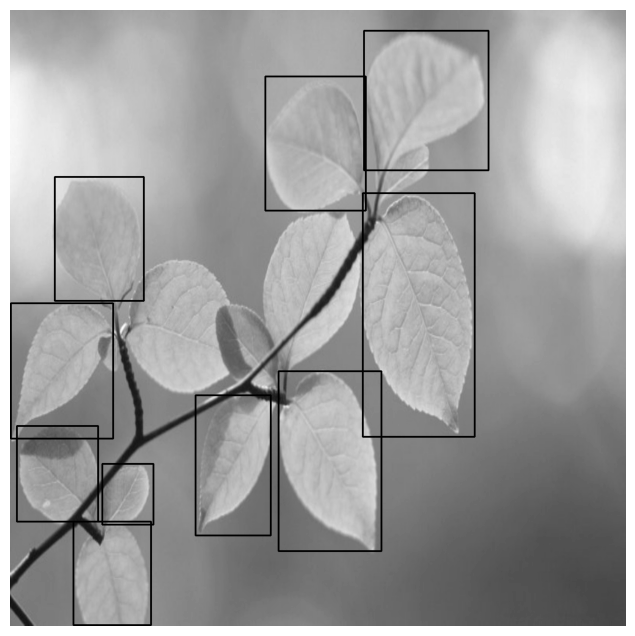

In [40]:

it = iter(train_data_loader)
get_sample_image(it)

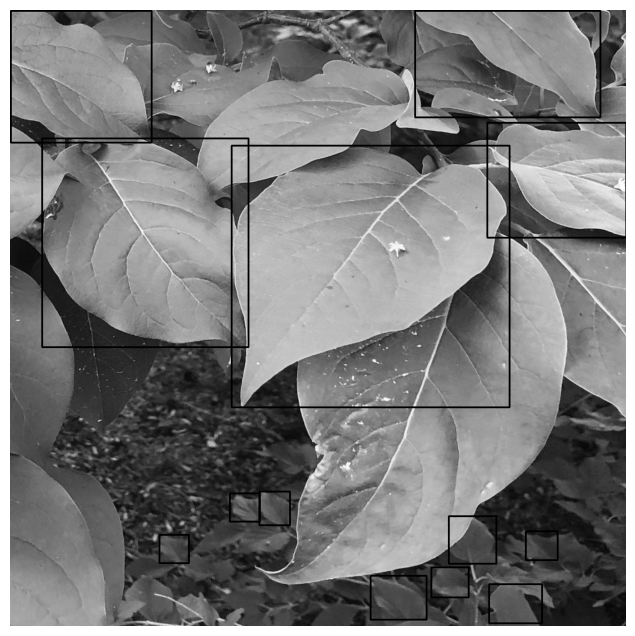

In [41]:
get_sample_image(it)

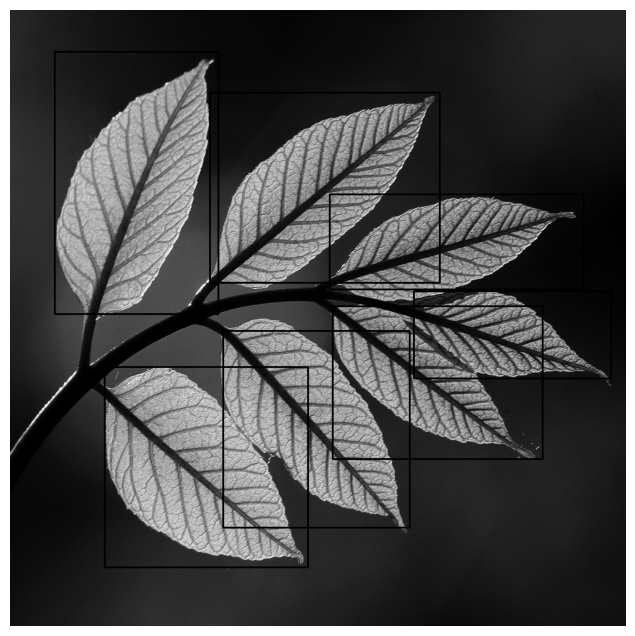

In [42]:
get_sample_image(it)

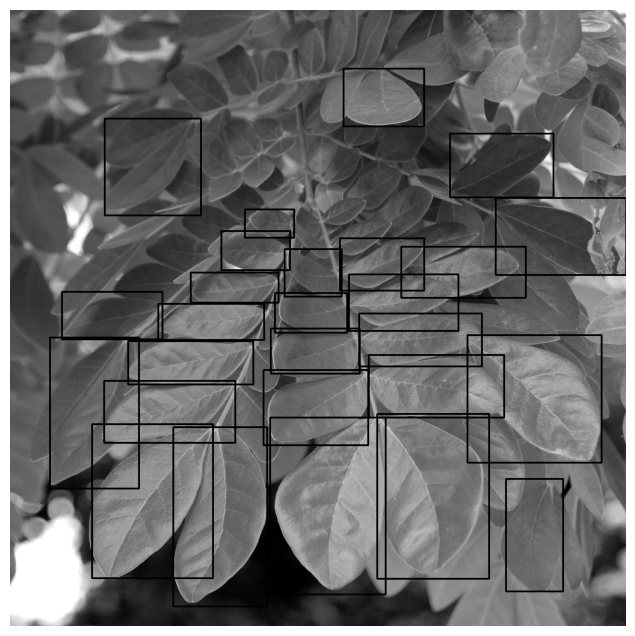

In [43]:
get_sample_image(it)

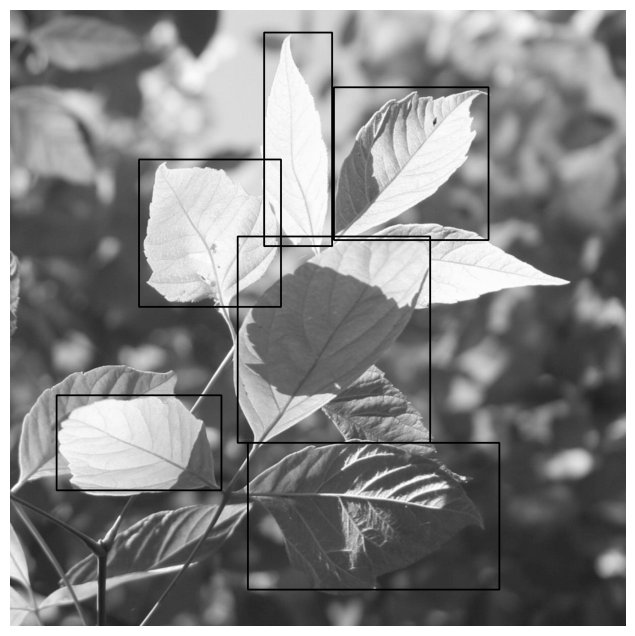

In [44]:
get_sample_image(it)

In [45]:
# get_sample_image(it)

In [46]:
# get_sample_image(it)

In [47]:
# get_sample_image(it)

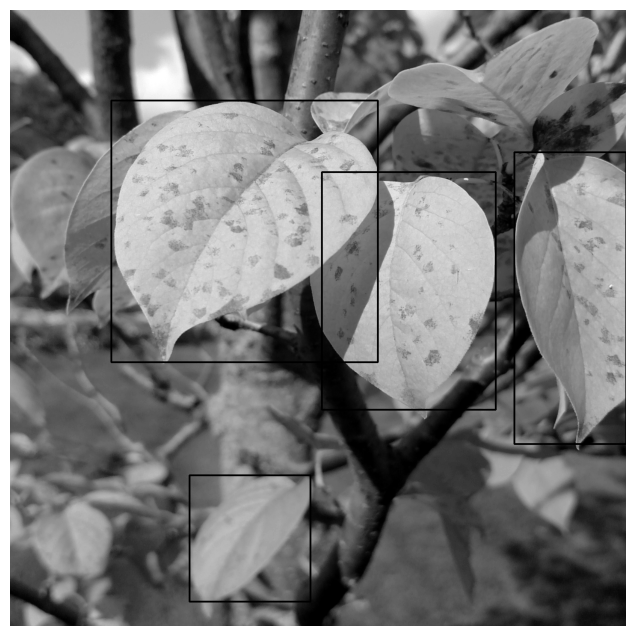

In [48]:
get_sample_image(it)

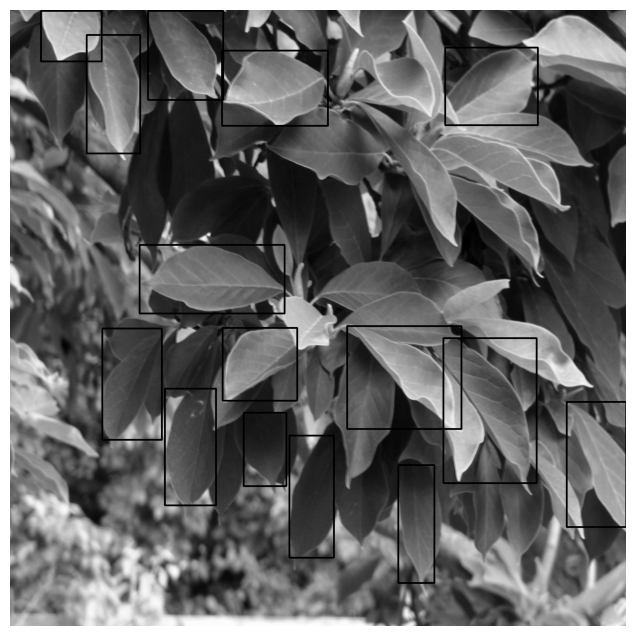

In [49]:
get_sample_image(it)


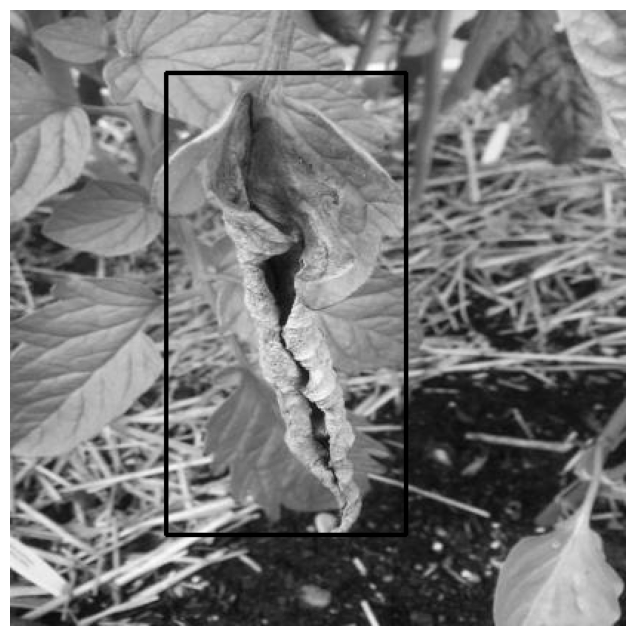

In [50]:
get_sample_image(it)

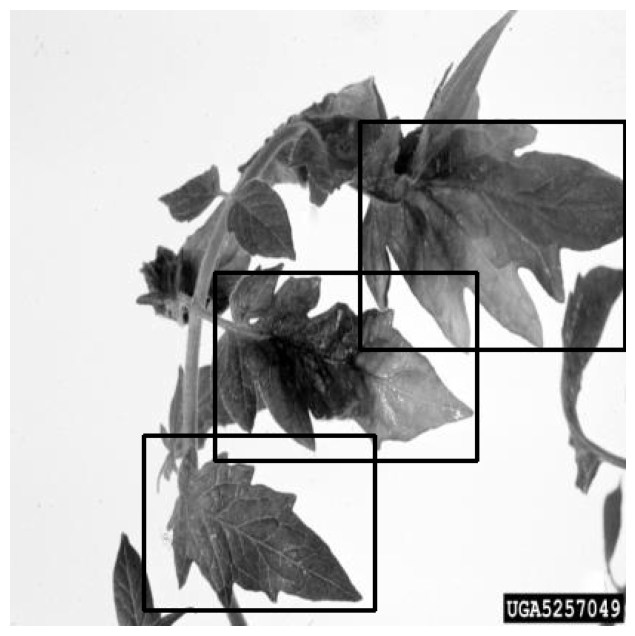

In [51]:
get_sample_image(it)

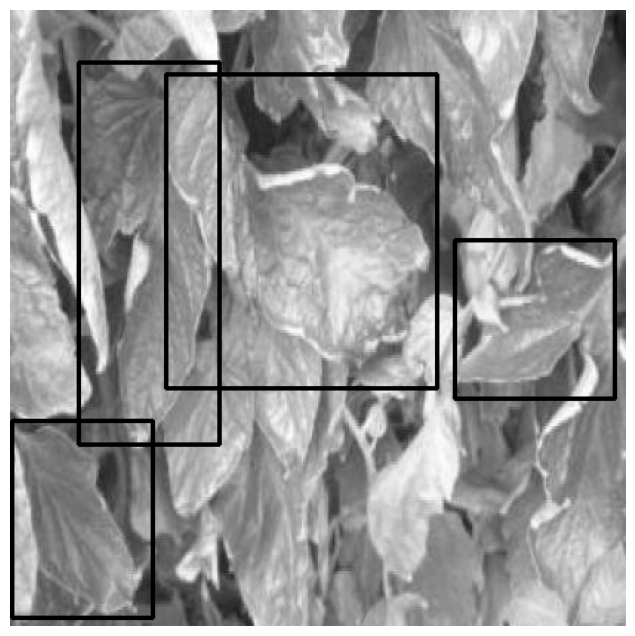

In [52]:
get_sample_image(it)

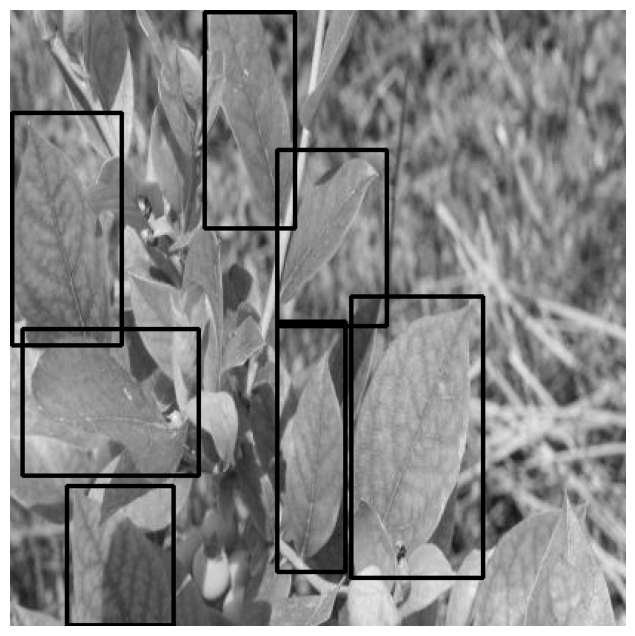

In [53]:
get_sample_image(it)

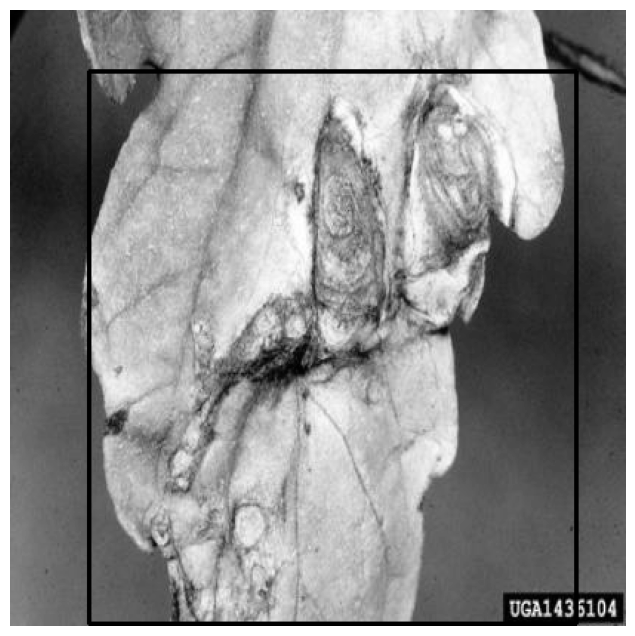

In [54]:
get_sample_image(it)


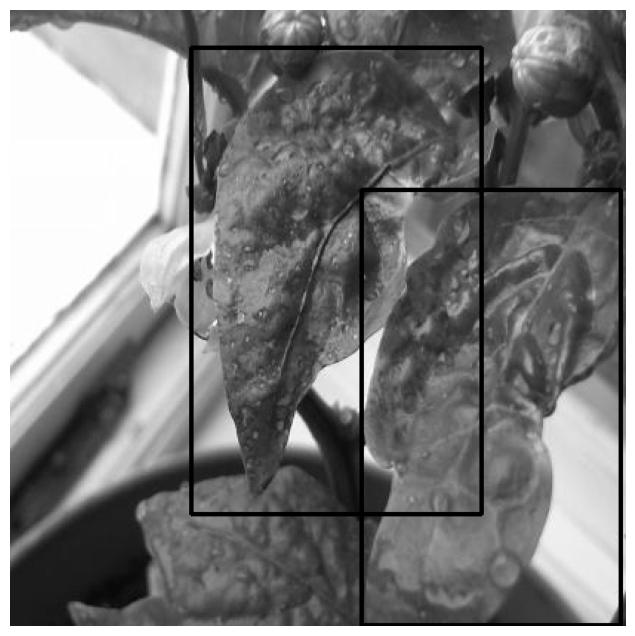

In [55]:
get_sample_image(it)

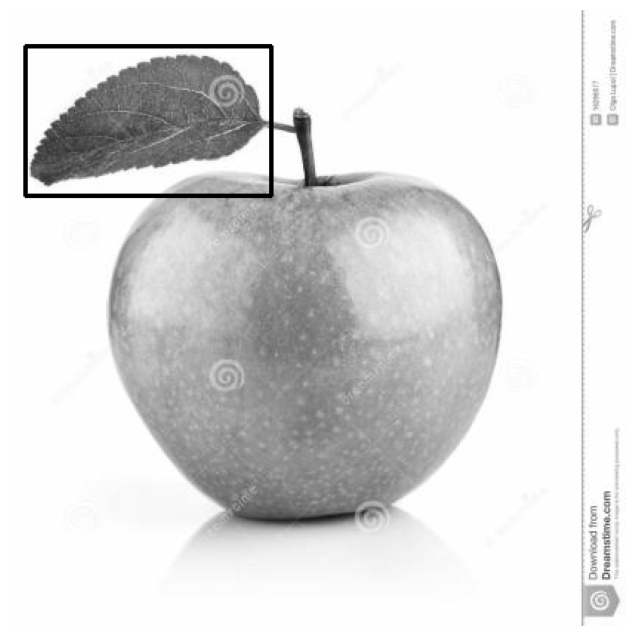

In [56]:
get_sample_image(it)

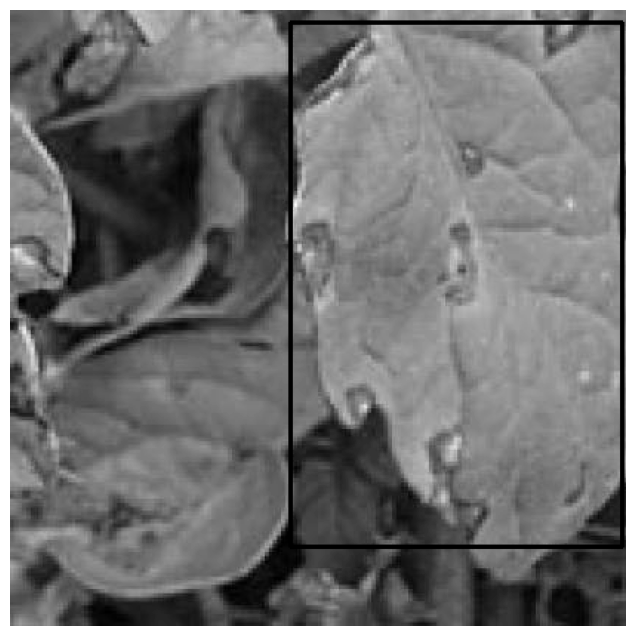

In [57]:
get_sample_image(it)

In [58]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 169MB/s]


In [59]:
model.to(device)
print("Model loaded")

Model loaded


In [60]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None
num_epochs = 10

In [61]:
loss_hist = Averager()
itr = 1
previous_epoch = 1000
es_rate = 0
es_threshold = 2

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

for epoch in range(num_epochs):
    loss_hist.reset()
    min_loss = 100

    for images, targets, image_ids in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_hist.send(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    if lr_scheduler is not None:
        lr_scheduler.step()
    min_loss = loss_hist.value

    if min_loss < previous_epoch:
        previous_epoch = min_loss
        es_rate = 0

    else:
        if es_rate < es_threshold:
            es_rate += 1
        elif es_rate >= es_threshold:
            break
    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.36630840516877516
Epoch #0 loss: 0.5197668998049386
Iteration #100 loss: 0.35596301353360904
Epoch #1 loss: 0.36617176200173274
Iteration #150 loss: 0.46954575842758806
Iteration #200 loss: 0.450776776140221
Epoch #2 loss: 0.3359836534067987
Iteration #250 loss: 0.4095912528670174
Epoch #3 loss: 0.31017809207859315
Iteration #300 loss: 0.276433955808433
Iteration #350 loss: 0.1098924330923299


In [ ]:
it = iter(valid_data_loader)

In [ ]:
get_validation_image(it)

In [ ]:
image_list = os.listdir(DIR_TEST+"/leaf")
print(image_list)

In [ ]:
it = iter(load_test_dataset())

In [ ]:
start = time.time()
get_test_image(it,0.5)


In [ ]:
print(time.time()-start)

In [ ]:
start = time.time()
get_test_image(it,0.5)

In [ ]:
print(time.time()-start)

In [ ]:
import random
from PIL import Image


directions = ["up", "down", "left", "right"]
images =[ "/content/drive/MyDrive/RGC PROJECT/correct_direction/up.png","/content/drive/MyDrive/RGC PROJECT/correct_direction/right.png",
         "/content/drive/MyDrive/RGC PROJECT/correct_direction/left.png","/content/drive/MyDrive/RGC PROJECT/correct_direction/down.png"]
# images = ["up.png", "down.png", "left.png", "right.png"]

correct_direction = random.choice(directions)
correct_image_path = random.choice(images)


user_section = [correct_direction, random.choice(images), random.choice(images), random.choice(images)]
random.shuffle(user_section)

correct_section = [correct_image_path]
for i in range(3):
  direction = random.choice(directions)
  image_path = random.choice(images)
  correct_section.append(image_path)
random.shuffle(correct_section)

correct_image = Image.open(correct_image_path)
user_images = [Image.open(image_path) for image_path in user_section]

print("Select the image with the", correct_direction, "direction:")
for i in range(4):
  user_images[i].show()
print("\n")
for i in range(4):
  Image.open(correct_section[i]).show()

user_input = input("\nEnter the correct image number (1-4): ")
if user_input == str(user_section.index(correct_direction) + 1):
  print("Success! You are not a robot.")
else:
  print("Incorrect. Please try again.")


In [ ]:
import random
from PIL import Image
import os

# list of directions and image paths
directions = ["up", "down", "left", "right"]
images_dir = "/content/drive/MyDrive/RGC PROJECT/correct_direction"
images = [os.path.join(images_dir, "up.png"),
          os.path.join(images_dir, "down.png"),
          os.path.join(images_dir, "left.png"),
          os.path.join(images_dir, "right.png")]

# select a random direction-based image and multiple direction images
correct_direction = random.choice(directions)
correct_image_path = os.path.join(images_dir, correct_direction + ".png")

# create two sections
user_section = [correct_direction, random.choice(images), random.choice(images), random.choice(images)]
random.shuffle(user_section)

correct_section = [correct_image_path]
for i in range(3):
  direction = random.choice(directions)
  image_path = os.path.join(images_dir, direction + ".png")
  correct_section.append(image_path)
random.shuffle(correct_section)

# load the images
correct_image = Image.open(correct_image_path)
user_images = [Image.open(image_path) for image_path in user_section[1:]]

# display the CAPTCHA
print("Select the image with the", correct_direction, "direction:")
for i in range(3):
  user_images[i].show()
print("\n")
Image.open(correct_image_path).show()

# validate the user's input
user_input = input("\nEnter the correct image number (1-4): ")
if user_input == str(user_section.index(correct_direction) + 1):
  print("Success! You are not a robot.")
else:
  print("Incorrect. Please try again.")
